# Example #2 Reuters: Chapter 3

Example of multiclass classification.

In [1]:
from keras.datasets import reuters
import numpy as np
import pandas as pd

from keras import models
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

Using TensorFlow backend.


## Load Data

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 2s 1us/step


## Examine Data

In [3]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def get_word(i):
    # Decodes the review. Note that the indices are offset by 3 because 0, 1, and 2 are
    # reserved indices for “padding,” “start of sequence,” and “unknown.”
    return reverse_word_index.get(i-3, '?')

def get_text(word_ids):
    return " ".join(get_word(wid) for wid in word_ids)

557056/550378 [==============================] - 1s 1us/step


In [4]:
#https://github.com/keras-team/keras/issues/12072#issuecomment-458905721
topic_indices = {'copper': 6, 'livestock': 28, 'gold': 25, 'money-fx': 19, 'ipi': 30, 'trade': 11,
                 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 'tin': 26, 'zinc': 37, 'jobs': 34,
                 'ship': 13, 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 'lead': 45, 'housing': 7,
                 'meal-feed': 22, 'gnp': 21, 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2,
                 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 'carcass': 15, 'lei': 35,
                 'gas': 41, 'nat-gas': 17, 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43,
                 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 'hog': 44, 'acq': 4,
                 'pet-chem': 39, 'grain': 1, 'retail': 29}

reverse_topics = { tid:topic for topic, tid in topic_indices.items()}

In [5]:
for i in range(0, 5):
    id = np.random.randint(0, len(train_data))
    text = get_text(train_data[id])

    display(HTML(f"<h2>ID: {id}</h2>"))
    display(HTML(f"Topic: {reverse_topics[train_labels[id]]}"))
    display(HTML(f"<textarea rows='10' cols='100'>{text}</textarea>"))

In [7]:
# Show top topics

topic_dist = (
    pd.Series(train_labels)
        .value_counts()
        .to_frame()
        .reset_index()
        .rename(columns={'index': 'TopicId', 0: 'Count'}))

topic_dist['TopicId'] = topic_dist.TopicId.astype('int')
topic_dist['Topic'] = topic_dist.TopicId.apply(reverse_topics.get)
topic_dist['Percent'] = 100 * topic_dist.Count / topic_dist.Count.sum()
topic_dist = topic_dist.sort_values(by='Count', ascending=False)
topic_dist.head(10)

,TopicId,Count,Topic,Percent
0,3,3159,earn,35.170341
1,4,1949,acq,21.698953
2,19,549,money-fx,6.112224
3,16,444,crude,4.943220
4,1,432,grain,4.809619
5,11,390,trade,4.342017
6,20,269,interest,2.994879
7,13,172,ship,1.914941
8,8,139,money-supply,1.547540
9,10,124,sugar,1.380539


## Prepare Data

In [8]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

input_features = x_train.shape[1]
output_features = one_hot_train_labels.shape[1]

## Train Model

In [9]:
def create_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(input_features,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(output_features, activation='softmax'))

    model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

def plot_training(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.gca().grid()
    plt.show()

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.gca().grid()
    plt.show()

Train on 6736 samples, validate on 2246 samples
Epoch 1/20
6736/6736 [==============================] - 2s 339us/step - loss: 2.8213 - accuracy: 0.5194 - val_loss: 1.9287 - val_accuracy: 0.6554
Epoch 2/20
6736/6736 [==============================] - 1s 208us/step - loss: 1.5735 - accuracy: 0.6829 - val_loss: 1.4483 - val_accuracy: 0.6794
Epoch 3/20
6736/6736 [==============================] - 1s 207us/step - loss: 1.1534 - accuracy: 0.7524 - val_loss: 1.2270 - val_accuracy: 0.7378
Epoch 4/20
6736/6736 [==============================] - 1s 202us/step - loss: 0.9158 - accuracy: 0.8106 - val_loss: 1.1302 - val_accuracy: 0.7600
Epoch 5/20
6736/6736 [==============================] - 1s 208us/step - loss: 0.7338 - accuracy: 0.8501 - val_loss: 1.0512 - val_accuracy: 0.7698
Epoch 6/20
6736/6736 [==============================] - 1s 203us/step - loss: 0.5929 - accuracy: 0.8775 - val_loss: 1.0032 - val_accuracy: 0.7792
Epoch 7/20
6736/6736 [==============================] - 1s 202us/step - loss

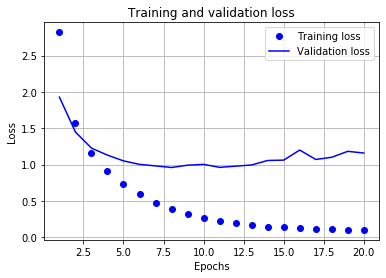

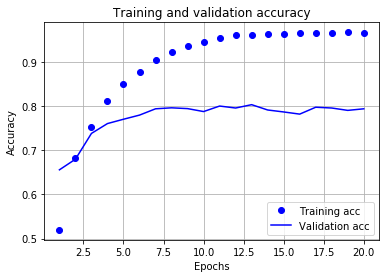

In [10]:
model = create_model()

history = model.fit(
    x_train,
    one_hot_train_labels,
    epochs=20,
    batch_size=512,
    validation_split=0.25)

plot_training(history)

In [11]:
model = create_model()

history = model.fit(
    x_train,
    one_hot_train_labels,
    epochs=9,
    batch_size=512)

Epoch 1/9
8982/8982 [==============================] - 1s 167us/step - loss: 2.4421 - accuracy: 0.5316
Epoch 2/9
8982/8982 [==============================] - 1s 155us/step - loss: 1.3362 - accuracy: 0.7192
Epoch 3/9
8982/8982 [==============================] - 1s 157us/step - loss: 0.9845 - accuracy: 0.7911
Epoch 4/9
8982/8982 [==============================] - 1s 156us/step - loss: 0.7662 - accuracy: 0.8383
Epoch 5/9
8982/8982 [==============================] - 1s 155us/step - loss: 0.5957 - accuracy: 0.8747
Epoch 6/9
8982/8982 [==============================] - 1s 154us/step - loss: 0.4721 - accuracy: 0.9017
Epoch 7/9
8982/8982 [==============================] - 1s 153us/step - loss: 0.3828 - accuracy: 0.9212
Epoch 8/9
8982/8982 [==============================] - 1s 155us/step - loss: 0.3135 - accuracy: 0.9338
Epoch 9/9
8982/8982 [==============================] - 1s 154us/step - loss: 0.2616 - accuracy: 0.9407


In [12]:
results = model.evaluate(x_test, one_hot_test_labels)
results

2246/2246 [==============================] - 1s 237us/step


[0.9721804682102356, 0.7898486256599426]

## Examine Results

In [13]:
probabilities = pd.DataFrame(model.predict(x_test))

In [14]:
predictions = pd.DataFrame()
predictions['Actual'] = y_test
predictions['ActualTopic'] = predictions.Actual.apply(lambda topic_id: reverse_topics.get(int(topic_id)))
predictions['Predicted'] = probabilities.idxmax(axis=1)
predictions['PredictedTopic'] = predictions.Predicted.apply(lambda topic_id: reverse_topics.get(int(topic_id)))
predictions['Probability'] = probabilities.max(axis=1)
predictions.head(10)

,Actual,ActualTopic,Predicted,PredictedTopic,Probability
0,3.0,earn,4,acq,0.500714
1,10.0,sugar,10,sugar,0.510894
2,1.0,grain,1,grain,0.883942
3,4.0,acq,4,acq,0.791347
4,4.0,acq,13,ship,0.969706
5,3.0,earn,3,earn,0.980037
6,3.0,earn,3,earn,0.812393
7,3.0,earn,3,earn,0.996962
8,3.0,earn,3,earn,0.996486
9,3.0,earn,3,earn,0.946335


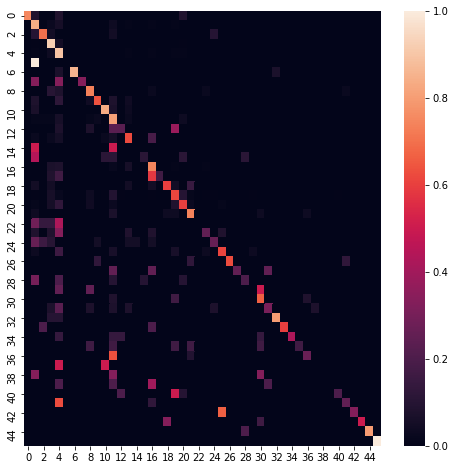

In [15]:
# Plot the confusion matrix
pd.set_option('max_columns', 100)
cf_df = pd.DataFrame(confusion_matrix(predictions.Actual.astype('int'), predictions.Predicted, normalize='true'))
plt.figure(figsize = (8,8))
sns.heatmap(cf_df, annot=False)
plt.show()

In [16]:
# Show some of the most confused topics
cf_flat = []
for i in range(0, len(cf_df)):
    for j in range(0, len(cf_df)):
        if i != j:
            v = cf_df.loc[i, j]
            cf_flat.append(pd.Series({
                'ActualId': i,
                'Actual': reverse_topics[i],
                'PredictedId': j,
                'Predicted': reverse_topics[j],
                'Value': v
            }))
            
cf_flat = pd.DataFrame(cf_flat)
cf_flat = cf_flat.sort_values(by='Value', ascending=False)
cf_flat[cf_flat.ActualId != cf_flat.PredictedId].head(15)

,ActualId,Actual,PredictedId,Predicted,Value
226,5,wheat,1,grain,1.000000
1915,42,silver,25,gold,0.666667
1631,36,bop,11,trade,0.636364
1849,41,gas,4,acq,0.625000
781,17,nat-gas,16,crude,0.583333
1819,40,dlr,19,money-fx,0.500000
1669,37,zinc,4,acq,0.500000
1334,29,retail,30,ipi,0.500000
1675,37,zinc,10,sugar,0.500000
631,14,cotton,1,grain,0.500000
